In [1]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import requests
import json


In [11]:
class_folder = "Sharks/"
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
root = "./data/" + class_folder
dataset = datasets.ImageFolder(root=root, transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [12]:
vgg19(pretrained=True)

c:\ProgramData\miniconda3\envs\env_gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\miniconda3\envs\env_gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [13]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((x.size(0), -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation extraction
    def get_activations(self, x):
        return self.features_conv(x)

In [14]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()
predictions = []

# get the image from the dataloader
for img, label in dataloader:
    # img, _ = next(iter(dataloader))
    # print(img.shape)
    # get the most likely prediction of the model
    pred = vgg(img)
    predictions.append(pred)

In [15]:
import json
import requests

# Load ImageNet class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(LABELS_URL)
labels = response.json()

for (idx, pred) in enumerate(predictions):
    
    _, indices = torch.topk(pred, 3)
    probabilities = torch.nn.functional.softmax(pred, dim=1)[0] * 100
    print("Photo index ", idx)
    # Print the predictions
    for idx in indices[0]:
        label = labels[idx]
        prob = probabilities[idx].item()
        print(f"    Predicted: ({label}, {prob:.2f}%)")


Photo index  0
    Predicted: (great white shark, 97.29%)
    Predicted: (tiger shark, 2.28%)
    Predicted: (hammerhead shark, 0.42%)


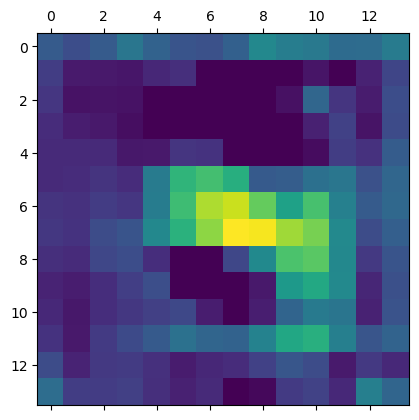

In [25]:
# dimensions = [ int(pred.argmax(dim=1)[0]) for pred in predictions]

# for (idx, dimension) in enumerate(dimensions):
#     # get the gradient of the output with respect to the parameters of the model
#     pred[:, dimension].backward()

#     # pull the gradients out of the model
#     gradients = vgg.get_activations_gradient()

#     # pool the gradients across the channels
#     pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

#     # get the activations of the last convolutional layer
#     activations = vgg.get_activations(img).detach()

#     # weight the channels by corresponding gradients
#     for i in range(512):
#         activations[:, i, :, :] *= pooled_gradients[i]
        
#     # average the channels of the activations
#     heatmap = torch.mean(activations, dim=1).squeeze()

#     # relu on top of the heatmap
#     # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
#     heatmap = np.maximum(heatmap, 0)

#     # normalize the heatmap
#     heatmap /= torch.max(heatmap)

#     # draw the heatmap
#     plt.matshow(heatmap.squeeze())
#     path_save = "heatmap_raw" + str(idx) + ".pdf"
#     plt.savefig(path_save)

In [16]:
def generate_heatmap(model, img): 
    pred = model(img)
    dimension = int(pred.argmax(dim=1)[0])
    pred[:, dimension].backward()
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(img).detach()
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().numpy(), 0)
    heatmap /= np.max(heatmap)
    return heatmap

In [17]:
def save_heatmap(heatmap, idx, output_folder):
    plt.matshow(heatmap.squeeze())
    path_save = os.path.join(output_folder, f"heatmap_raw_{idx}.pdf")
    plt.savefig(path_save)
    plt.close()

In [18]:
def superimpose_and_save(heatmap, img_path, idx, output_folder):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    superimposed_path = os.path.join(output_folder, f"superimposed_{idx}.jpg")
    cv2.imwrite(superimposed_path, superimposed_img)

In [9]:
# import cv2

# img = cv2.imread('./data/Elephants/data/02.jpg')

# heatmap = np.array(heatmap)

# heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap = np.uint8(255 * heatmap)

# heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# superimposed_img = heatmap * 0.4 + img

# cv2.imwrite('./map.jpg', superimposed_img)

Processing complete. Superimposed images saved to: ./data/Elephants/output_images/


In [19]:
output_folder = "./data/" + class_folder + "outputs"
os.makedirs(output_folder, exist_ok=True)

for idx, (img, _) in enumerate(dataloader):
    heatmap = generate_heatmap(vgg, img)
    save_heatmap(heatmap, idx, output_folder)
    img_path = dataloader.dataset.imgs[idx][0]
    superimpose_and_save(heatmap, img_path, idx, output_folder)